In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(os.path.join(data_dir, 'train_data.npz'))
val_data = np.load(os.path.join(data_dir, 'validation_data.npz'))
test_data = np.load(os.path.join(data_dir, 'test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 25443),
 (36805,),
 (4293, 25443),
 (4293,),
 (4815, 25443),
 (4815,),
 (16, 2))

In [6]:
def preprocess(x_data):
    x_data = np.reshape(x_data, [x_data.shape[0], 99, 257, 1])
    x_data = np.rot90(x_data, 1, (1, 2))
    return x_data

In [7]:
output_size = y_table.shape[0]

In [8]:
x_train_2d = preprocess(x_train)
mean_vals = np.mean(x_train_2d, axis=0)
std_val = np.std(x_train_2d)
x_train_2d_norm = (x_train_2d-mean_vals) / std_val
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_2d = preprocess(x_val)
x_val_2d_norm = (x_val_2d-mean_vals) / std_val
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_2d = preprocess(x_test)
x_test_2d_norm = (x_test_2d-mean_vals) / std_val
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [9]:
input_shape = x_test_2d_norm[0].shape

In [10]:
def build_cnn_do_bn(conv_num=1, fcn_num=1):
    model=Sequential()
    model.add(Conv2D (kernel_size=5, filters=8, strides=(1,1), padding='valid', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv2D (kernel_size=5, filters=8*(2**(i+1)), strides=(1,1), padding='valid'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))

    model.add(Flatten())
    
    for i in range(fcn_num):
        model.add(Dense(1024/(2**i)))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
    
    model.add(Dense(output_size, activation='softmax' ))
    return model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.6090 - acc: 0.5076
Epoch 00001: val_loss improved from inf to 0.96782, saving model to model/checkpoint/2D_CNN_DO_BN_1_conv_1_fcn_checkpoint/01-0.9678.hdf5
36805/36805 [==============================] - 26s 695us/sample - loss: 1.6086 - acc: 0.5077 - val_loss: 0.9678 - val_acc: 0.7051
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.0403 - acc: 0.6681
Epoch 00002: val_loss improved from 0.96782 to 0.76927, saving model to model/checkpoint/2D_CNN_DO_BN_1_conv_1_fcn_checkpoint/02-0.7693.hdf5
36805/36805 [==============================] - 24s 658us/sample - loss: 1.0404 - acc: 0.6681 - val_loss: 0.7693 - va

Epoch 25/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1247 - acc: 0.9616
Epoch 00025: val_loss did not improve from 0.50057
36805/36805 [==============================] - 24s 642us/sample - loss: 0.1247 - acc: 0.9616 - val_loss: 0.6121 - val_acc: 0.8684
Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1110 - acc: 0.9666
Epoch 00026: val_loss did not improve from 0.50057
36805/36805 [==============================] - 23s 633us/sample - loss: 0.1111 - acc: 0.9666 - val_loss: 0.6285 - val_acc: 0.8675
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1128 - acc: 0.9656
Epoch 00027: val_loss did not improve from 0.50057
36805/36805 [==============================] - 23s 632us/sample - loss: 0.1128 - acc: 0.9656 - val_loss: 0.6330 - val_acc: 0.8663
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0991 - acc: 0.9697
Epoch 00028: val_loss did not improve from 0.50057
36805/36805 [=====

Epoch 55/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0674 - acc: 0.9809
Epoch 00055: val_loss did not improve from 0.50057
36805/36805 [==============================] - 23s 624us/sample - loss: 0.0674 - acc: 0.9809 - val_loss: 0.7760 - val_acc: 0.8679
Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0567 - acc: 0.9838
Epoch 00056: val_loss did not improve from 0.50057
36805/36805 [==============================] - 23s 626us/sample - loss: 0.0567 - acc: 0.9838 - val_loss: 0.7786 - val_acc: 0.8717
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0461 - acc: 0.9860
Epoch 00057: val_loss did not improve from 0.50057
36805/36805 [==============================] - 23s 619us/sample - loss: 0.0461 - acc: 0.9860 - val_loss: 0.7753 - val_acc: 0.8705
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0518 - acc: 0.9848
Epoch 00058: val_loss did not improve from 0.50057
36805/36805 [=====

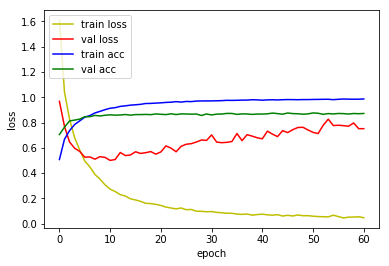

4815/4815 [==============================] - 1s 192us/sample - loss: 0.6062 - acc: 0.8380
Loss: 0.6061678386675359 Accuracy: 0.83800626

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.1662 - acc: 0.3425
Epoch 00001: val_loss improved from inf to 1.33086, saving model to model/checkpoint/2D_CNN_DO_BN_1_conv_2_fcn_checkpoint/01-1.3309.hdf5
36805/36805 [==============================] - 25s 684us/sample - loss: 2.1662 - acc: 0.3425 - val_loss: 1.3309 - val_acc: 0.6012
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.5235 - acc: 0.5185
Epoch 00002: val_loss improved from 1.33086 to 1.02309, saving model to model/checkpoint/2D_CNN_DO_BN_1_conv_2_fcn_checkpoint/02-1.0231.hdf5
36805/36805 [==============================] - 24s 640us/sample - loss: 1.5234 - acc: 0.5185 - val_loss: 1.0231 - val_acc: 0.6935
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.2548 - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.2870 - acc: 0.9105
Epoch 00025: val_loss did not improve from 0.48450
36805/36805 [==============================] - 23s 631us/sample - loss: 0.2870 - acc: 0.9106 - val_loss: 0.4928 - val_acc: 0.8717
Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.2716 - acc: 0.9147
Epoch 00026: val_loss did not improve from 0.48450
36805/36805 [==============================] - 23s 627us/sample - loss: 0.2716 - acc: 0.9147 - val_loss: 0.5145 - val_acc: 0.8707
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.2636 - acc: 0.9169
Epoch 00027: val_loss did not improve from 0.48450
36805/36805 [==============================] - 23s 629us/sample - loss: 0.2636 - acc: 0.9169 - val_loss: 0.5239 - val_acc: 0.8672
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.2507 - acc: 0.9223
Epoch 00028: val_loss did not improve from 0.48450
36805/36805 [==================

Epoch 55/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1429 - acc: 0.9574
Epoch 00055: val_loss did not improve from 0.48450
36805/36805 [==============================] - 23s 633us/sample - loss: 0.1429 - acc: 0.9574 - val_loss: 0.5911 - val_acc: 0.8637
Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1386 - acc: 0.9571
Epoch 00056: val_loss did not improve from 0.48450
36805/36805 [==============================] - 23s 629us/sample - loss: 0.1386 - acc: 0.9571 - val_loss: 0.5889 - val_acc: 0.8679
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1341 - acc: 0.9590
Epoch 00057: val_loss did not improve from 0.48450
36805/36805 [==============================] - 23s 634us/sample - loss: 0.1341 - acc: 0.9590 - val_loss: 0.6000 - val_acc: 0.8696
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1277 - acc: 0.9617
Epoch 00058: val_loss did not improve from 0.48450
36805/36805 [=====

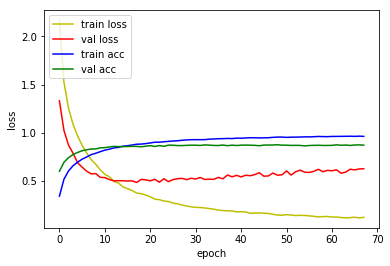

4815/4815 [==============================] - 1s 223us/sample - loss: 0.6061 - acc: 0.8301
Loss: 0.6060772022973216 Accuracy: 0.83011425

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.4500 - acc: 0.5589
Epoch 00001: val_loss improved from inf to 0.78933, saving model to model/checkpoint/2D_CNN_DO_BN_2_conv_1_fcn_checkpoint/01-0.7893.hdf5
36805/36805 [==============================] - 22s 598us/sample - loss: 1.4500 - acc: 0.5589 - val_loss: 0.7893 - val_acc: 0.7664
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.8151 - acc: 0.7470
Epoch 00002: val_loss improved from 0.78933 to 0.55811, saving model to model/checkpoint/2D_CNN_DO_BN_2_conv_1_fcn_checkpoint/02-0.5581.hdf5
36805/36805 [==============================] - 19s 527us/sample - loss: 0.8150 - acc: 0.7470 - val_loss: 0.5581 - val_acc: 0.8376
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.5951 - 

Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0409 - acc: 0.9887
Epoch 00026: val_loss did not improve from 0.31000
36805/36805 [==============================] - 19s 526us/sample - loss: 0.0411 - acc: 0.9887 - val_loss: 0.3655 - val_acc: 0.9236
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0429 - acc: 0.9875
Epoch 00027: val_loss did not improve from 0.31000
36805/36805 [==============================] - 20s 534us/sample - loss: 0.0429 - acc: 0.9875 - val_loss: 0.3400 - val_acc: 0.9243
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0320 - acc: 0.9912
Epoch 00028: val_loss did not improve from 0.31000
36805/36805 [==============================] - 20s 532us/sample - loss: 0.0321 - acc: 0.9912 - val_loss: 0.3354 - val_acc: 0.9257
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9890
Epoch 00029: val_loss did not improve from 0.31000
36805/36805 [=====

Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0124 - acc: 0.9965
Epoch 00056: val_loss did not improve from 0.31000
36805/36805 [==============================] - 19s 515us/sample - loss: 0.0124 - acc: 0.9965 - val_loss: 0.4128 - val_acc: 0.9229
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0126 - acc: 0.9966
Epoch 00057: val_loss did not improve from 0.31000
36805/36805 [==============================] - 19s 515us/sample - loss: 0.0126 - acc: 0.9966 - val_loss: 0.3837 - val_acc: 0.9271
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0111 - acc: 0.9973
Epoch 00058: val_loss did not improve from 0.31000
36805/36805 [==============================] - 19s 519us/sample - loss: 0.0111 - acc: 0.9973 - val_loss: 0.3800 - val_acc: 0.9262
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0116 - acc: 0.9967
Epoch 00059: val_loss did not improve from 0.31000
36805/36805 [=====

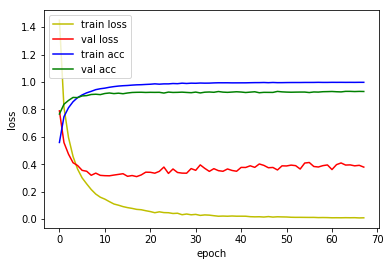

4815/4815 [==============================] - 1s 253us/sample - loss: 0.4205 - acc: 0.8926
Loss: 0.4205304691972267 Accuracy: 0.8926272

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.0047 - acc: 0.3717
Epoch 00001: val_loss improved from inf to 1.13440, saving model to model/checkpoint/2D_CNN_DO_BN_2_conv_2_fcn_checkpoint/01-1.1344.hdf5
36805/36805 [==============================] - 23s 627us/sample - loss: 2.0048 - acc: 0.3718 - val_loss: 1.1344 - val_acc: 0.6723
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.2779 - acc: 0.5925
Epoch 00002: val_loss improved from 1.13440 to 0.80873, saving model to model/checkpoint/2D_CNN_DO_BN_2_conv_2_fcn_checkpoint/02-0.8087.hdf5
36805/36805 [==============================] - 20s 539us/sample - loss: 1.2778 - acc: 0.5926 - val_loss: 0.8087 - val_acc: 0.7757
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.9807 - a

Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0868 - acc: 0.9714
Epoch 00026: val_loss did not improve from 0.30493
36805/36805 [==============================] - 20s 539us/sample - loss: 0.0868 - acc: 0.9714 - val_loss: 0.3200 - val_acc: 0.9252
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0786 - acc: 0.9763
Epoch 00027: val_loss did not improve from 0.30493
36805/36805 [==============================] - 20s 550us/sample - loss: 0.0786 - acc: 0.9763 - val_loss: 0.3337 - val_acc: 0.9259
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0734 - acc: 0.9774
Epoch 00028: val_loss did not improve from 0.30493
36805/36805 [==============================] - 20s 537us/sample - loss: 0.0734 - acc: 0.9774 - val_loss: 0.3433 - val_acc: 0.9252
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0745 - acc: 0.9771
Epoch 00029: val_loss did not improve from 0.30493
36805/36805 [=====

Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0252 - acc: 0.9926
Epoch 00056: val_loss did not improve from 0.30493
36805/36805 [==============================] - 20s 535us/sample - loss: 0.0252 - acc: 0.9926 - val_loss: 0.3956 - val_acc: 0.9259
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 0.9927
Epoch 00057: val_loss did not improve from 0.30493
36805/36805 [==============================] - 20s 533us/sample - loss: 0.0253 - acc: 0.9927 - val_loss: 0.3908 - val_acc: 0.9283
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0230 - acc: 0.9928
Epoch 00058: val_loss did not improve from 0.30493
36805/36805 [==============================] - 20s 530us/sample - loss: 0.0230 - acc: 0.9928 - val_loss: 0.3692 - val_acc: 0.9299
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0252 - acc: 0.9924
Epoch 00059: val_loss did not improve from 0.30493
36805/36805 [=====

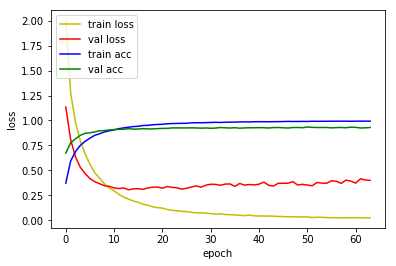

4815/4815 [==============================] - 1s 276us/sample - loss: 0.4075 - acc: 0.8845
Loss: 0.4075392654813586 Accuracy: 0.8845275

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.4398 - acc: 0.5510
Epoch 00001: val_loss improved from inf to 0.76051, saving model to model/checkpoint/2D_CNN_DO_BN_3_conv_1_fcn_checkpoint/01-0.7605.hdf5
36805/36805 [==============================] - 20s 554us/sample - loss: 1.4398 - acc: 0.5510 - val_loss: 0.7605 - val_acc: 0.7759
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.7241 - acc: 0.7726
Epoch 00002: val_loss improved from 0.76051 to 0.46607, saving model to model/checkpoint/2D_CNN_DO_BN_3_conv_1_fcn_checkpoint/02-0.4661.hdf5
36805/36805 [==============================] - 17s 469us/sample - loss: 0.7241 - acc: 0.7726 - val_loss: 0.4661 - val_acc: 0.8651
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.5020 - a

Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0439 - acc: 0.9867
Epoch 00026: val_loss did not improve from 0.20277
36805/36805 [==============================] - 18s 483us/sample - loss: 0.0439 - acc: 0.9867 - val_loss: 0.2236 - val_acc: 0.9464
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0421 - acc: 0.9870
Epoch 00027: val_loss did not improve from 0.20277
36805/36805 [==============================] - 17s 469us/sample - loss: 0.0421 - acc: 0.9870 - val_loss: 0.2225 - val_acc: 0.9527
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0392 - acc: 0.9880
Epoch 00028: val_loss did not improve from 0.20277
36805/36805 [==============================] - 17s 472us/sample - loss: 0.0392 - acc: 0.9880 - val_loss: 0.2279 - val_acc: 0.9453
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0378 - acc: 0.9882
Epoch 00029: val_loss did not improve from 0.20277
36805/36805 [=====

Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0165 - acc: 0.9953
Epoch 00056: val_loss did not improve from 0.20277
36805/36805 [==============================] - 17s 472us/sample - loss: 0.0165 - acc: 0.9953 - val_loss: 0.2646 - val_acc: 0.9532
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0152 - acc: 0.9955
Epoch 00057: val_loss did not improve from 0.20277
36805/36805 [==============================] - 17s 472us/sample - loss: 0.0153 - acc: 0.9955 - val_loss: 0.3001 - val_acc: 0.9420
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0173 - acc: 0.9947
Epoch 00058: val_loss did not improve from 0.20277
36805/36805 [==============================] - 17s 475us/sample - loss: 0.0173 - acc: 0.9947 - val_loss: 0.2574 - val_acc: 0.9522
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0144 - acc: 0.9958
Epoch 00059: val_loss did not improve from 0.20277
36805/36805 [=====

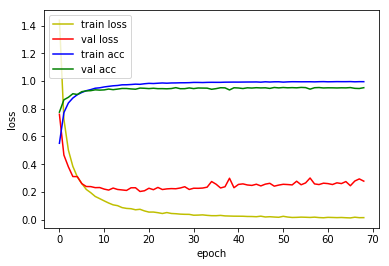

4815/4815 [==============================] - 1s 297us/sample - loss: 0.2913 - acc: 0.9254
Loss: 0.2912604559742897 Accuracy: 0.9254413

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.9539 - acc: 0.3875
Epoch 00001: val_loss improved from inf to 1.10006, saving model to model/checkpoint/2D_CNN_DO_BN_3_conv_2_fcn_checkpoint/01-1.1001.hdf5
36805/36805 [==============================] - 23s 631us/sample - loss: 1.9538 - acc: 0.3875 - val_loss: 1.1001 - val_acc: 0.6692
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.1411 - acc: 0.6345
Epoch 00002: val_loss improved from 1.10006 to 0.65479, saving model to model/checkpoint/2D_CNN_DO_BN_3_conv_2_fcn_checkpoint/02-0.6548.hdf5
36805/36805 [==============================] - 18s 490us/sample - loss: 1.1410 - acc: 0.6345 - val_loss: 0.6548 - val_acc: 0.8069
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.8208 - a

Epoch 25/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0834 - acc: 0.9733
Epoch 00025: val_loss did not improve from 0.20065
36805/36805 [==============================] - 18s 499us/sample - loss: 0.0836 - acc: 0.9733 - val_loss: 0.2255 - val_acc: 0.9446
Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0820 - acc: 0.9733
Epoch 00026: val_loss did not improve from 0.20065
36805/36805 [==============================] - 19s 507us/sample - loss: 0.0819 - acc: 0.9733 - val_loss: 0.2302 - val_acc: 0.9495
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0707 - acc: 0.9771
Epoch 00027: val_loss improved from 0.20065 to 0.20029, saving model to model/checkpoint/2D_CNN_DO_BN_3_conv_2_fcn_checkpoint/27-0.2003.hdf5
36805/36805 [==============================] - 18s 501us/sample - loss: 0.0707 - acc: 0.9771 - val_loss: 0.2003 - val_acc: 0.9532
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.9910
Epoch 00054: val_loss did not improve from 0.20029
36805/36805 [==============================] - 19s 510us/sample - loss: 0.0289 - acc: 0.9910 - val_loss: 0.2528 - val_acc: 0.9529
Epoch 55/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0297 - acc: 0.9918
Epoch 00055: val_loss did not improve from 0.20029
36805/36805 [==============================] - 19s 504us/sample - loss: 0.0297 - acc: 0.9918 - val_loss: 0.2389 - val_acc: 0.9543
Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0276 - acc: 0.9919
Epoch 00056: val_loss did not improve from 0.20029
36805/36805 [==============================] - 19s 506us/sample - loss: 0.0276 - acc: 0.9919 - val_loss: 0.2414 - val_acc: 0.9518
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9917
Epoch 00057: val_loss did not improve from 0.20029
36805/36805 [==================

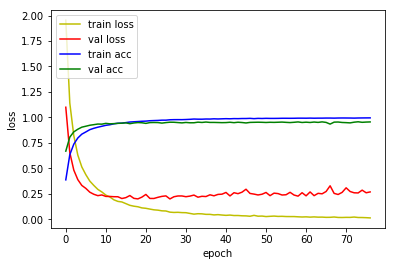

4815/4815 [==============================] - 1s 310us/sample - loss: 0.2936 - acc: 0.9240
Loss: 0.2935926984403735 Accuracy: 0.92398757

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.5624 - acc: 0.5045
Epoch 00001: val_loss improved from inf to 0.79857, saving model to model/checkpoint/2D_CNN_DO_BN_4_conv_1_fcn_checkpoint/01-0.7986.hdf5
36805/36805 [==============================] - 24s 645us/sample - loss: 1.5624 - acc: 0.5046 - val_loss: 0.7986 - val_acc: 0.7638
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.7288 - acc: 0.7707
Epoch 00002: val_loss improved from 0.79857 to 0.48467, saving model to model/checkpoint/2D_CNN_DO_BN_4_conv_1_fcn_checkpoint/02-0.4847.hdf5
36805/36805 [==============================] - 16s 448us/sample - loss: 0.7286 - acc: 0.7708 - val_loss: 0.4847 - val_acc: 0.8574
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.5173 - 

Epoch 26/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0510 - acc: 0.9847
Epoch 00026: val_loss did not improve from 0.18731
36805/36805 [==============================] - 16s 433us/sample - loss: 0.0509 - acc: 0.9847 - val_loss: 0.1990 - val_acc: 0.9513
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0475 - acc: 0.9851
Epoch 00027: val_loss did not improve from 0.18731
36805/36805 [==============================] - 16s 431us/sample - loss: 0.0475 - acc: 0.9851 - val_loss: 0.2485 - val_acc: 0.9455
Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0480 - acc: 0.9851
Epoch 00028: val_loss did not improve from 0.18731
36805/36805 [==============================] - 16s 431us/sample - loss: 0.0480 - acc: 0.9851 - val_loss: 0.2112 - val_acc: 0.9502
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0494 - acc: 0.9852
Epoch 00029: val_loss did not improve from 0.18731
36805/36805 [=====

Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0222 - acc: 0.9933
Epoch 00056: val_loss did not improve from 0.18731
36805/36805 [==============================] - 16s 440us/sample - loss: 0.0222 - acc: 0.9933 - val_loss: 0.2280 - val_acc: 0.9548
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0171 - acc: 0.9951
Epoch 00057: val_loss did not improve from 0.18731
36805/36805 [==============================] - 16s 440us/sample - loss: 0.0171 - acc: 0.9951 - val_loss: 0.2100 - val_acc: 0.9564
Epoch 58/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0167 - acc: 0.9954
Epoch 00058: val_loss did not improve from 0.18731
36805/36805 [==============================] - 16s 445us/sample - loss: 0.0167 - acc: 0.9954 - val_loss: 0.2160 - val_acc: 0.9536
Epoch 59/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0163 - acc: 0.9952
Epoch 00059: val_loss did not improve from 0.18731
36805/36805 [=====

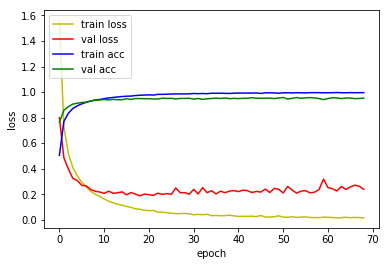

4815/4815 [==============================] - 2s 321us/sample - loss: 0.2755 - acc: 0.9225
Loss: 0.27550793761157294 Accuracy: 0.92253375

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.9375 - acc: 0.3865
Epoch 00001: val_loss improved from inf to 1.06002, saving model to model/checkpoint/2D_CNN_DO_BN_4_conv_2_fcn_checkpoint/01-1.0600.hdf5
36805/36805 [==============================] - 25s 692us/sample - loss: 1.9375 - acc: 0.3865 - val_loss: 1.0600 - val_acc: 0.6758
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.0497 - acc: 0.6583
Epoch 00002: val_loss improved from 1.06002 to 0.60427, saving model to model/checkpoint/2D_CNN_DO_BN_4_conv_2_fcn_checkpoint/02-0.6043.hdf5
36805/36805 [==============================] - 17s 457us/sample - loss: 1.0496 - acc: 0.6583 - val_loss: 0.6043 - val_acc: 0.8139
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.7211 -

Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0814 - acc: 0.9733
Epoch 00026: val_loss did not improve from 0.18739
36805/36805 [==============================] - 17s 456us/sample - loss: 0.0814 - acc: 0.9733 - val_loss: 0.2136 - val_acc: 0.9518
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0778 - acc: 0.9736
Epoch 00027: val_loss did not improve from 0.18739
36805/36805 [==============================] - 17s 453us/sample - loss: 0.0778 - acc: 0.9736 - val_loss: 0.2004 - val_acc: 0.9511
Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0747 - acc: 0.9749
Epoch 00028: val_loss did not improve from 0.18739
36805/36805 [==============================] - 17s 466us/sample - loss: 0.0748 - acc: 0.9748 - val_loss: 0.2060 - val_acc: 0.9476
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0714 - acc: 0.9767
Epoch 00029: val_loss did not improve from 0.18739
36805/36805 [=====

Epoch 56/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0323 - acc: 0.9901
Epoch 00056: val_loss did not improve from 0.18739
36805/36805 [==============================] - 16s 446us/sample - loss: 0.0322 - acc: 0.9901 - val_loss: 0.2231 - val_acc: 0.9592
Epoch 57/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9904
Epoch 00057: val_loss did not improve from 0.18739
36805/36805 [==============================] - 16s 439us/sample - loss: 0.0292 - acc: 0.9904 - val_loss: 0.2774 - val_acc: 0.9513
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0300 - acc: 0.9903
Epoch 00058: val_loss did not improve from 0.18739
36805/36805 [==============================] - 16s 444us/sample - loss: 0.0300 - acc: 0.9903 - val_loss: 0.2284 - val_acc: 0.9585
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9914
Epoch 00059: val_loss did not improve from 0.18739
36805/36805 [=====

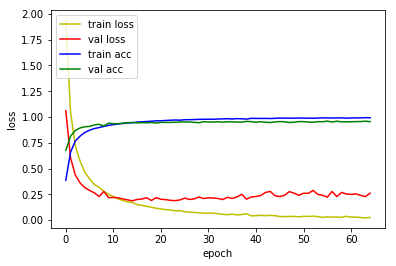

4815/4815 [==============================] - 2s 368us/sample - loss: 0.2545 - acc: 0.9202
Loss: 0.2545351875781518 Accuracy: 0.9202492



In [11]:
for i in range(1, 5):
    for j in range(1, 3):
        model_name = '2D_CNN_DO_BN_{}_conv_{}_fcn'.format(i, j)
        model = build_cnn_do_bn(conv_num=i, fcn_num=j)
#         model.summary()
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])
    
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'.format(i, j)
        os.makedirs(model_path, exist_ok=True)
        model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
        checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                       verbose=1, save_best_only=True)

        early_stopping = EarlyStopping(monitor='val_loss', patience=50)
        hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=200, 
                         validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                         callbacks = [checkpointer, early_stopping])

        print()
        print(model_name, 'Model'.format(i, j))
        fig, ax = plt.subplots()
        ax.plot(hist.history['loss'], 'y', label='train loss')
        ax.plot(hist.history['val_loss'], 'r', label='val loss')
        ax.plot(hist.history['acc'], 'b', label='train acc')
        ax.plot(hist.history['val_acc'], 'g', label='val acc')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(loc='upper left')
        plt.show()
        
        png_path = 'visualization/learning_curve/'
        filename = model_name+'.png'
        os.makedirs(png_path, exist_ok=True)
        fig.savefig(png_path+filename, transparent=True)
        
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
        model = load_model(model_filename)
        [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        print()
        
        del(model)

In [12]:
for i in range(1, 5):
    for j in range(1, 3):
        model_name = '2D_CNN_DO_BN_{}_conv_{}_fcn'.format(i, j)
        print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'
  
        model = load_model(model_filename)
        model.summary()
    
        [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        print()
        
        del(model)

2D_CNN_DO_BN_1_conv_1_fcn Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 253, 95, 8)        208       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 253, 95, 8)        32        
_________________________________________________________________
activation (Activation)      (None, 253, 95, 8)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 48, 8)        0         
_________________________________________________________________
flatten (Flatten)            (None, 48768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              49939456  
_________________________________________________________________
activation_1 (Activation)    (None, 1024)   

4815/4815 [==============================] - 2s 353us/sample - loss: 0.4075 - acc: 0.8845
Loss: 0.4075392654813586 Accuracy: 0.8845275

2D_CNN_DO_BN_3_conv_1_fcn Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 253, 95, 8)        208       
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 253, 95, 8)        32        
_________________________________________________________________
activation_12 (Activation)   (None, 253, 95, 8)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 48, 8)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 123, 44, 16)       3216      
_________________________________________________________________
batch_normalization_v1_7 (Ba (None, 123,

4815/4815 [==============================] - 2s 440us/sample - loss: 0.2755 - acc: 0.9225
Loss: 0.27550793761157294 Accuracy: 0.92253375

2D_CNN_DO_BN_4_conv_2_fcn Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 253, 95, 8)        208       
_________________________________________________________________
batch_normalization_v1_16 (B (None, 253, 95, 8)        32        
_________________________________________________________________
activation_26 (Activation)   (None, 253, 95, 8)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 127, 48, 8)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 123, 44, 16)       3216      
_________________________________________________________________
batch_normalization_v1_17 (B (None, 12